In [2]:
import os
import nibabel as nb
import numpy as np
import matplotlib.pyplot as pl
import scipy as sp
from scipy.signal import savgol_filter
from skimage.transform import rotate

%matplotlib inline

In [27]:
def sg_filter_cii(cii_file, polyorder=3, deriv=0, window_length=210, tr=1):

    # cii data
    cii_in = nb.load(cii_file)

    window = np.int(window_length / tr)
    if window % 2 == 0:
        window += 1

    data = cii_in.get_data()
    data_filt = savgol_filter(data.T, window_length=window, polyorder=polyorder,
                              deriv=deriv, axis=1, mode='nearest').T
    data_filt = data - data_filt + data_filt.mean(axis=0)

    cii_out = nb.Cifti2Image(dataobj=data_filt, 
                            header=cii_in.header, 
                            nifti_header=cii_in.nifti_header, 
                            extra=cii_in.extra)

    out_name = os.path.splitext(cii_file)[0] + '_sg.nii'
    out_file = os.path.abspath(out_name)
    nb.save(cii_out, out_file)
    
def psc_cii(cii_file, method='median'):

    # cii data
    cii_in = nb.load(cii_file)

    data = cii_in.get_data()
    if method == 'mean':
        data_m = data.mean(axis=0)
    elif method == 'median':
        data_m = np.median(data, axis=0)

    data_conv = 100.0 * (data - data_m)/data_m

    cii_out = nb.Cifti2Image(dataobj=data_conv, 
                            header=cii_in.header, 
                            nifti_header=cii_in.nifti_header, 
                            extra=cii_in.extra)

    out_name = os.path.splitext(cii_file)[0] + '_psc.nii'
    out_file = os.path.abspath(out_name)
    nb.save(cii_out, out_file)

In [20]:
cii_filename = 'tfMRI_RETCCW_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries.nii'

In [25]:
sg_filter_cii(cii_file=cii_filename)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [28]:
cii_filename = 'tfMRI_RETCCW_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_sg.nii'
psc_cii(cii_file=cii_filename, method='median')

In [29]:
cii = nb.load('tfMRI_RETCCW_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_sg_psc.nii')
ciid = cii.get_data()

In [30]:
ciid.shape

(300, 91282)

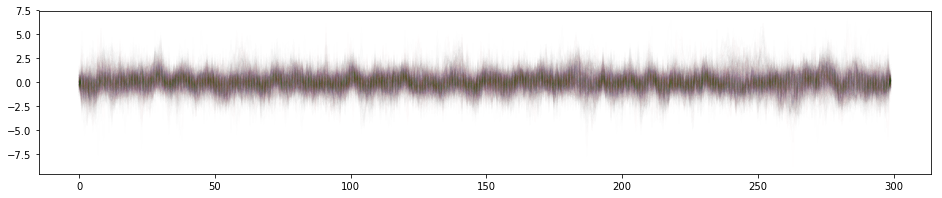

In [39]:
f = pl.figure(figsize=(16,3))
pl.plot(ciid[:,31000:32000], alpha=0.002)
pl.show()

In [ ]:
cii2 = nb.Cifti2Image

In [17]:
cii.file_map

{'image': <nibabel.fileholders.FileHolder at 0x814a142b0>}

In [83]:
direction='CW'
pre_post_blank=22
n_steps=32
n_reps=8
size=0.25
n_pix=100

In [92]:
X,Y = np.meshgrid(np.linspace(-1, 1, n_pix, endpoint=True), np.linspace(-1, 1, n_pix, endpoint=True))
ecc_mask = np.sqrt(X**2+Y**2) <= 1.01

dm = np.zeros((n_steps*n_reps+2*pre_post_blank, n_pix, n_pix), dtype=bool)

start_wedge = (X >= 0) & (Y >= 0) * ecc_mask

if direction == 'CW':
    dir_multiply = 1
elif direction == 'CCW':
    dir_multiply = -1
rotation_angles = dir_multiply * 360.0 * np.arange(0,n_steps) / n_steps
one_cycle = np.array([rotate(start_wedge, rs) for rs in rotation_angles])

for rep in range(n_reps):
    these_tps = pre_post_blank + rep*n_steps
    dm[these_tps:these_tps+n_steps,:,:] = one_cycle

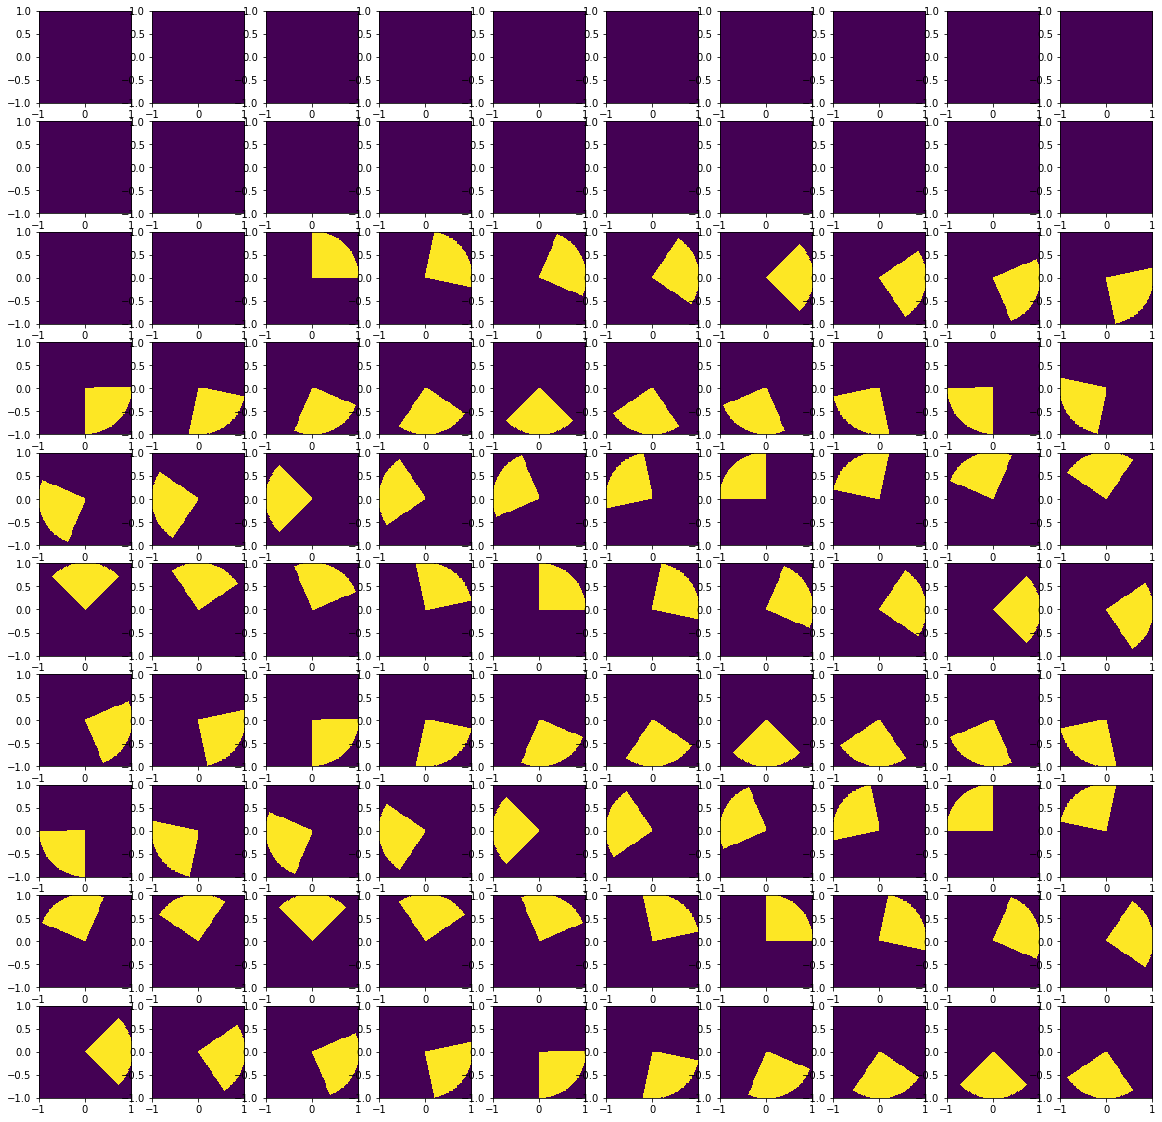

In [97]:
dim=17
f, ss = pl.subplots(dim,dim, figsize=(20,20))
pl_nr = 0
for i in np.arange(0,dim):
    for j in np.arange(0,dim):
        ss[i,j].imshow(dm[pl_nr], extent=[-1,1,-1,1], origin='lower')
        pl_nr += 1
pl.show()

In [7]:
def design_matrix_wedge(direction='CW',
                        pre_post_blank=22, 
                        n_steps=32, 
                        n_reps=8, 
                        size=0.25, 
                        n_pix=100):
    """design_matrix_wedge creates a wedge design matrix"""

    X,Y = np.meshgrid(np.linspace(-1, 1, n_pix, endpoint=True), np.linspace(-1, 1, n_pix, endpoint=True))
    ecc_mask = np.sqrt(X**2+Y**2) <= 1.01

    dm = np.zeros((n_steps*n_reps+2*pre_post_blank, n_pix, n_pix), dtype=bool)

    start_wedge = (X >= 0) & (Y >= 0) * ecc_mask

    if direction == 'CW':
        dir_multiply = 1
    elif direction == 'CCW':
        dir_multiply = -1
    rotation_angles = dir_multiply * 360.0 * np.arange(0,n_steps) / n_steps
    one_cycle = np.array([rotate(start_wedge, rs) for rs in rotation_angles])

    for rep in range(n_reps):
        these_tps = pre_post_blank + rep*n_steps
        dm[these_tps:these_tps+n_steps,:,:] = one_cycle
    
    return dm.astype(bool)

def design_matrix_ring(direction='EXP',
                        pre_post_blank=22, 
                        n_stim_steps=28, 
                        n_blank_steps=4,
                        n_reps=8, 
                        size_slope=0.5, 
                        n_pix=100):
    """design_matrix_wedge creates a wedge design matrix"""

    total_steps = (n_stim_steps+n_blank_steps)

    X,Y = np.meshgrid(np.linspace(-1, 1, n_pix, endpoint=True), np.linspace(-1, 1, n_pix, endpoint=True))
    ecc = np.sqrt(X**2+Y**2)

    ecc_pos_steps = np.linspace(0.75/n_stim_steps,0.75,n_stim_steps, endpoint=True)
    ecc_size_steps = np.linspace(size_slope/n_stim_steps,size_slope,n_stim_steps, endpoint=True)

    dm = np.zeros((total_steps*n_reps+2*pre_post_blank, n_pix, n_pix), dtype=bool)

    if direction == 'EXP':
        dir_indices = np.arange(n_stim_steps)
    elif direction == 'CON':
        dir_indices = np.arange(n_stim_steps)[::-1]

    one_cycle = np.zeros((total_steps, n_pix, n_pix))
    for i, p,s in zip(np.arange(n_stim_steps), ecc_pos_steps, ecc_size_steps):
        s2 = s/2.0
        one_cycle[i] = (ecc >= (p-s2)) & (ecc <= (p+s2))

    # invert direction for CON
    one_cycle[:n_stim_steps] = one_cycle[dir_indices]

    for rep in range(n_reps):
        these_tps = pre_post_blank + rep*total_steps
        dm[these_tps:these_tps+total_steps,:,:] = one_cycle
    
    return dm.astype(bool)

dm_w = design_matrix_wedge(direction='CW')
dm_r = design_matrix_ring(direction='EXP')

In [8]:
print(dm_r.shape)
print(dm_w.shape)

(300, 100, 100)
(300, 100, 100)


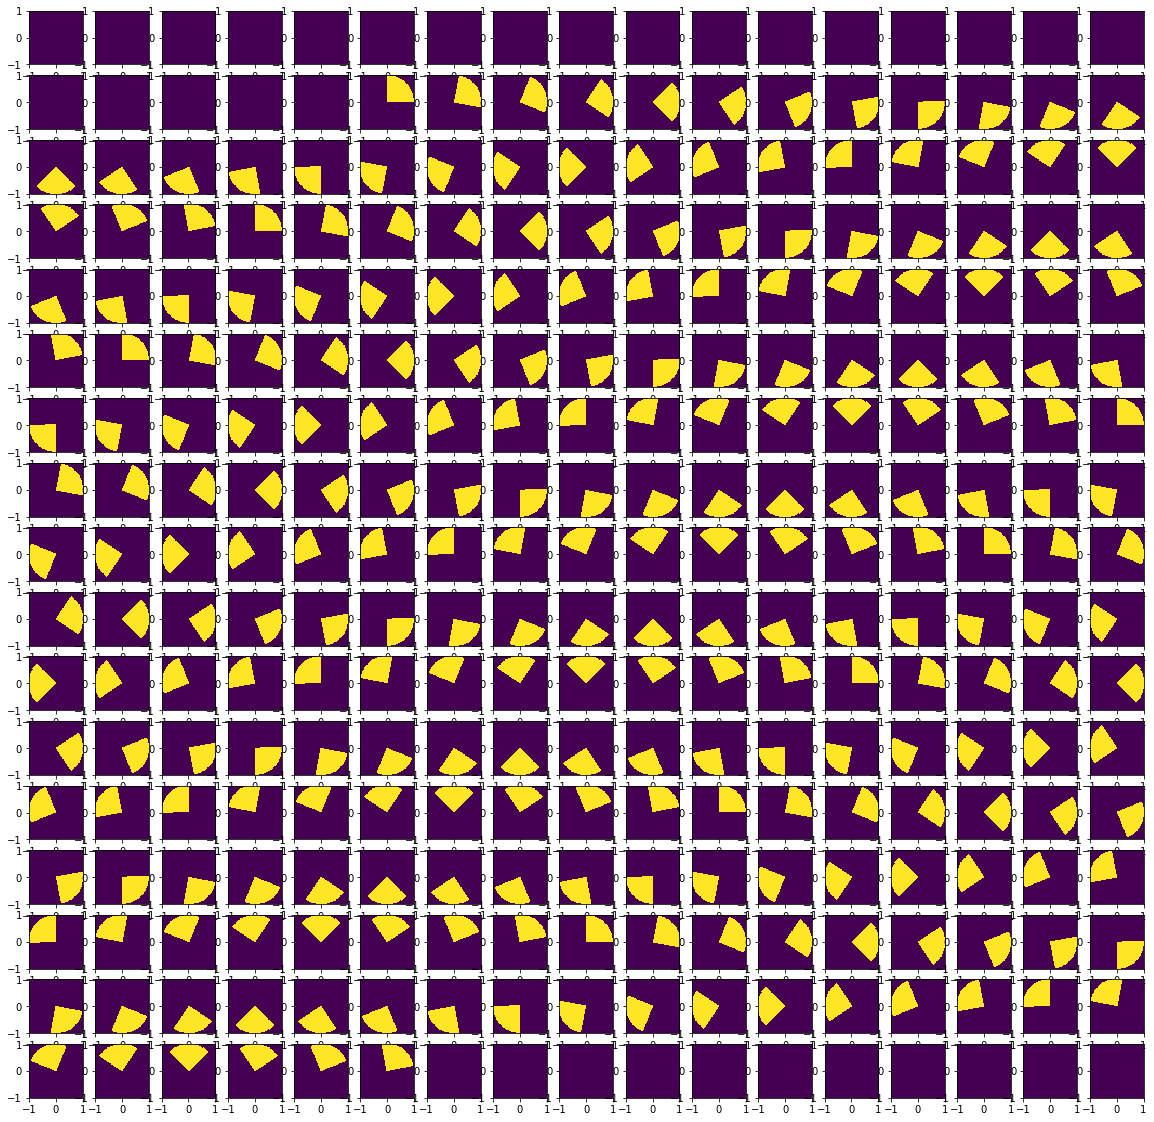

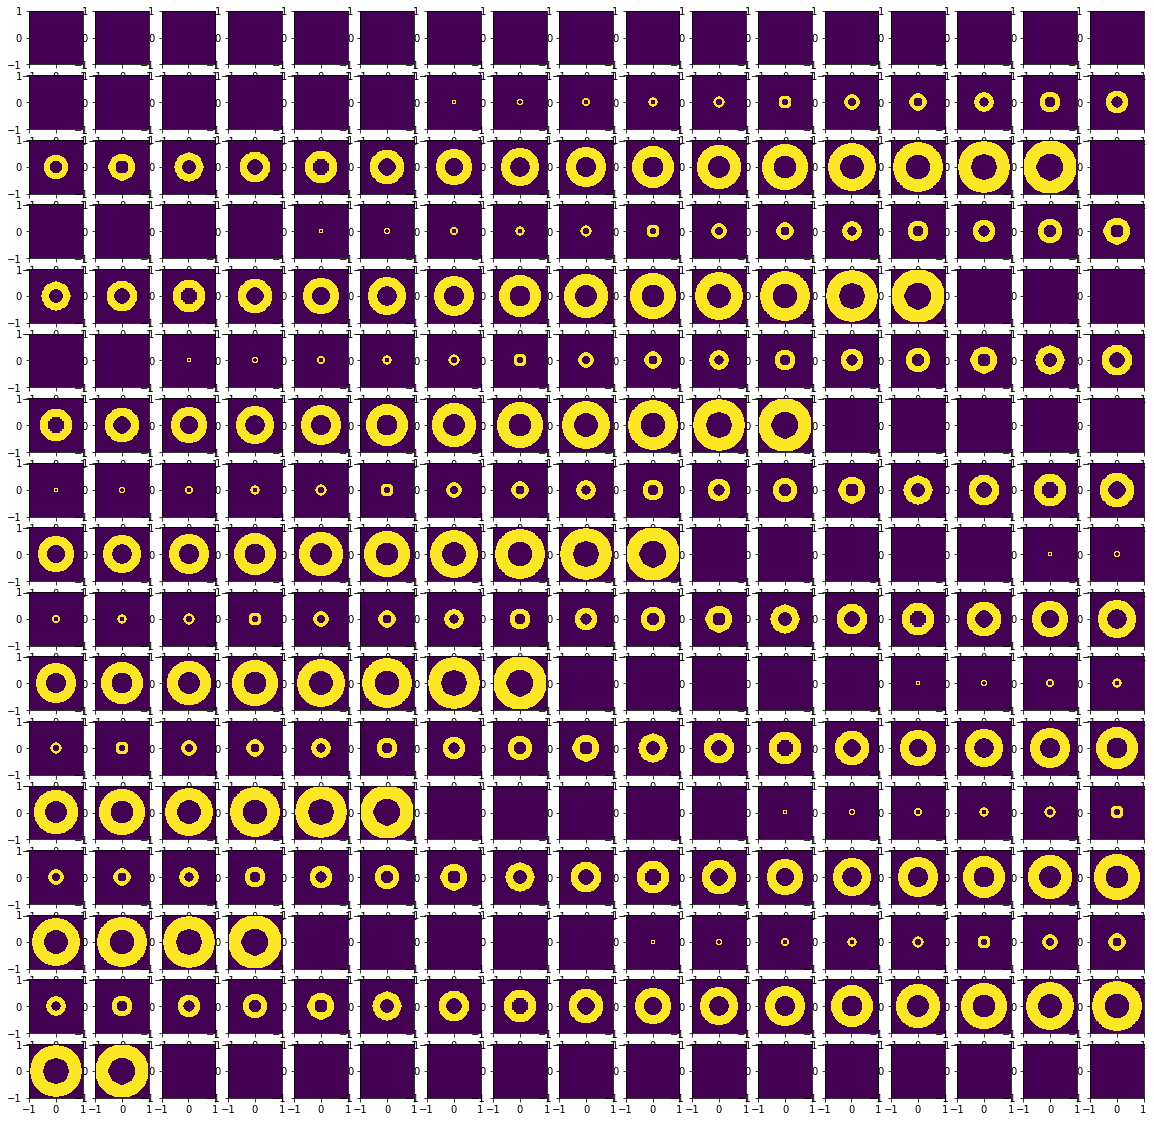

In [9]:
dim=17
f, ss = pl.subplots(dim,dim, figsize=(20,20))
pl_nr = 0
for i in np.arange(0,dim):
    for j in np.arange(0,dim):
        ss[i,j].imshow(dm_w[pl_nr], extent=[-1,1,-1,1], origin='lower')
        pl_nr += 1
pl.show()
f, ss = pl.subplots(dim,dim, figsize=(20,20))
pl_nr = 0
for i in np.arange(0,dim):
    for j in np.arange(0,dim):
        ss[i,j].imshow(dm_r[pl_nr], extent=[-1,1,-1,1], origin='lower')
        pl_nr += 1
pl.show()

In [10]:
def design_matrix_prf(pre_post_blank=16, 
                        n_stim_steps=28, 
                        n_blank_steps=4,
                        n_reps=8, 
                        bar_width=0.25, # of range 2 instead of 1
                        n_pix=100,
                        intermezzo_blank_steps=12,
                        directions=[0,-90,-180,-270,-45,-135,-225,-315]):

    s2 = bar_width/2.0
    total_steps = (n_stim_steps+n_blank_steps)

    X,Y = np.meshgrid(np.linspace(-1, 1, n_pix, endpoint=True), np.linspace(-1, 1, n_pix, endpoint=True))
    ecc_mask = np.sqrt(X**2+Y**2) <= 1.01

    dm = np.zeros((intermezzo_blank_steps+total_steps*n_reps+2*pre_post_blank, n_pix, n_pix), dtype=bool)

    one_cycle = np.zeros((total_steps, n_pix, n_pix))
    x_steps = np.linspace(-1, 1, n_stim_steps, endpoint=True)
    for i, x in enumerate(x_steps):
        one_cycle[i] = (X >= (x-s2)) & (X <= (x+s2)) & ecc_mask

    start_point = pre_post_blank
    for i, d in enumerate(directions):
        for t in np.arange(total_steps):
            dm[start_point+t] = rotate(one_cycle[t], d)
        if i == (len(directions)/2-1):
            print('halfway %i %i'%(d,i))
            start_point += intermezzo_blank_steps
        start_point += total_steps

    return np.round(dm).astype(bool)

dm_p = design_matrix_prf()
print(dm_p.shape)

halfway -270 3
(300, 100, 100)


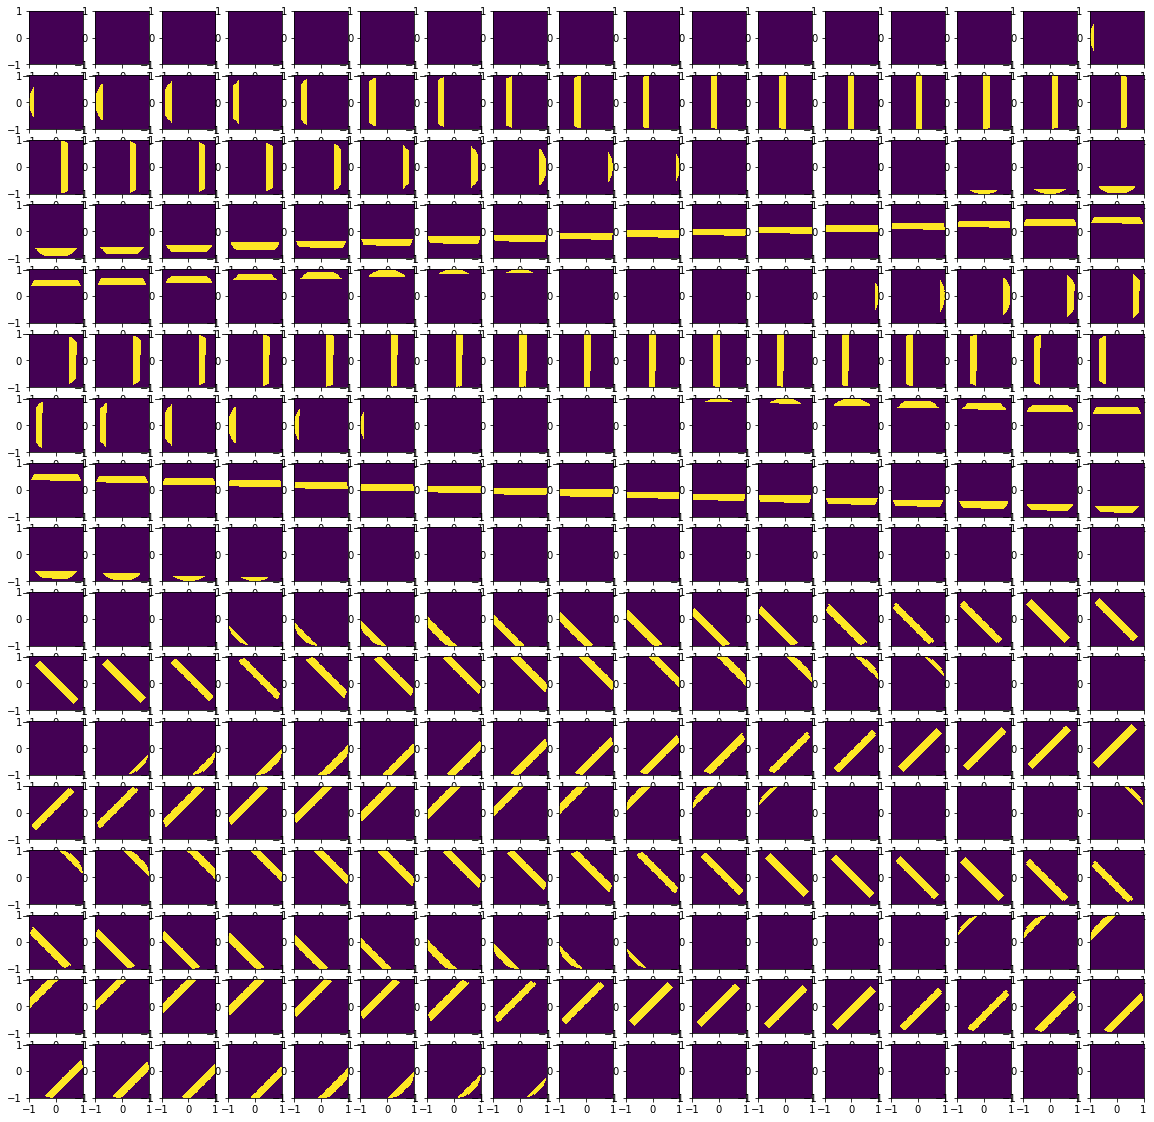

In [11]:
dim=17
f, ss = pl.subplots(dim,dim, figsize=(20,20))
pl_nr = 0
for i in np.arange(0,dim):
    for j in np.arange(0,dim):
        ss[i,j].imshow(dm_p[pl_nr], extent=[-1,1,-1,1], origin='lower')
        pl_nr += 1
pl.show()

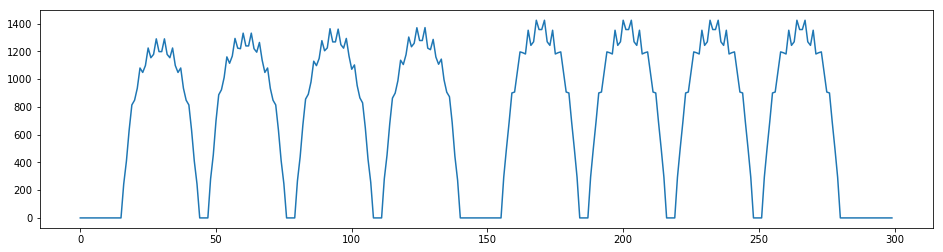

In [141]:
f=pl.figure(figsize = (16,4))
pl.plot(dm.sum(axis=(1,2)))